In [84]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [72]:
#Concatenated all 760 take_all_buildup data into a single worksheet and uploaded the dataframe into python
df = pd.read_excel("760_all.xlsx") 

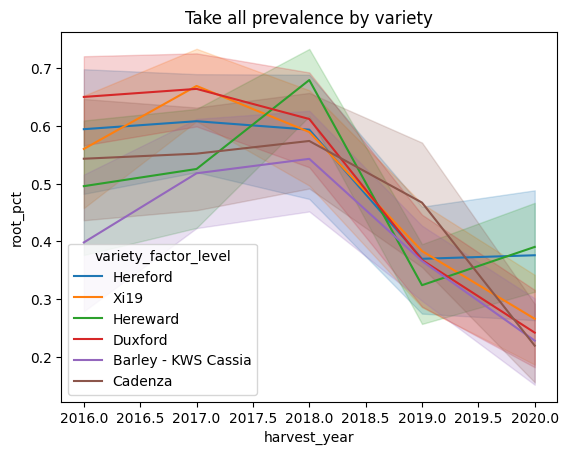

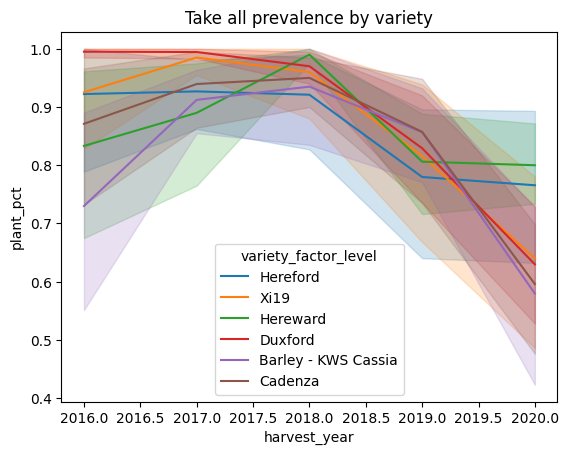

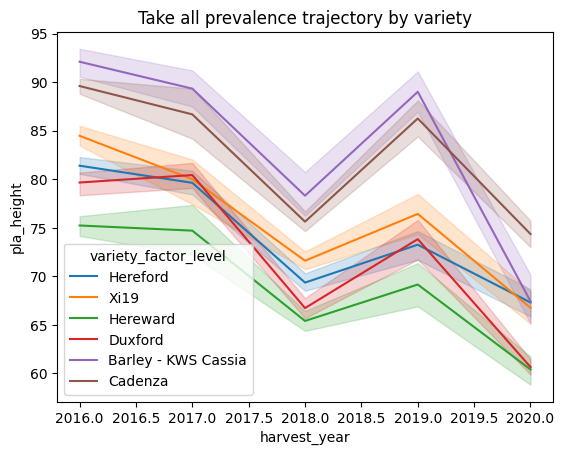

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

### PROCESS ###
##Graphing to visualize the the trends for the plant features between 2016-2020

df['root_pct'] = df["ww_rts_tkal_cnt"] / df["ww_rts_cnt"]
df.dropna(subset = ['root_pct'], inplace=True)

#Line graph for between harvest year and root percent infected, seperated by variety
sns.lineplot(data = df, x = "harvest_year", y = "root_pct", hue = "variety_factor_level", estimator = "mean")
plt.title("Take all prevalence by variety")
plt.show()

#Line graph between take harvest year and plant_pct, seperated by variety
df['plant_pct'] = df['ww_pla_tkal_cnt'] / df['ww_pla_cnt']
sns.lineplot( data = df, x = "harvest_year", y = "plant_pct", hue = "variety_factor_level", estimator = "mean")
plt.title("Take all prevalence by variety")
plt.show()

#Line graph between take harvest year and pla_height, seperated by variety
#Plant hieght does account for natural plant height in the first year
sns.lineplot(data = df, x = "harvest_year", y = "pla_height",hue = "variety_factor_level", estimator = "mean")
plt.title("Take all prevalence trajectory by variety")
plt.show()

In [74]:
### QUESTION ###
#Is there a significant difference between Low and High Inoculum wheat varieties?

### CODE ###
tab_high_low = df[(df['tab_variety_type'] == 'HIGH') | (df['tab_variety_type'] == 'LOW')]

model1 = sm.GLM.from_formula("root_pct ~ C(tab_variety_type) * C(harvest_year)",  data = tab_high_low,family = sm.families.Binomial(), freq_weights = tab_high_low["ww_rts_cnt"]).fit()
print(model1.summary())

#We run a Binomial Generalized Linear Model to test whenever there is a significant difference between high and low values for plants infected

### RESULTS ###
#Based on the model, there appears to be an interaction between year and LOW/HIGH

#Doing the same but with plant percent infected
model2 = sm.GLM.from_formula("plant_pct ~ C(tab_variety_type) * C(harvest_year)", data = tab_high_low, family = sm.families.Binomial(), freq_weights = tab_high_low["ww_pla_cnt"]).fit()
print(model2.summary())

### RESULTS ###
#There appears to to be a significant difference between the two variety types
#It appears that roots infected is a more powerful predictor compared to plants infected, so infection intensity should be carefully considered
#in the modeling process.

                 Generalized Linear Model Regression Results                  
Dep. Variable:               root_pct   No. Observations:                  200
Model:                            GLM   Df Residuals:                    11399
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5415.1
Date:                Sat, 06 Dec 2025   Deviance:                       2199.7
Time:                        17:59:41   Pearson chi2:                 2.02e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9721
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [75]:
#Finding the difference between the different wheat varieties for root percent

#Finding the differences while using Cadenza as the baseline in the Binomial model provides an early estimate into which varieties
#are classified as LOW or HIGH based on year variety type.
model_variety = sm.GLM.from_formula("root_pct ~ C(variety_factor_level, Treatment(reference='Cadenza')) * C(harvest_year)", data = df, family = sm.families.Binomial(), freq_weights = df["ww_rts_cnt"]).fit()

print(model_variety.summary())

#Without using plant height, we can see that Barley is also LOW inoculum
#However, this model should consider that the HIGH inoculum also has a lower root_pct on average, although it's the highest mid takeall lifecycle

                 Generalized Linear Model Regression Results                  
Dep. Variable:               root_pct   No. Observations:                  598
Model:                            GLM   Df Residuals:                    34459
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16208.
Date:                Sat, 06 Dec 2025   Deviance:                       6540.9
Time:                        17:59:41   Pearson chi2:                 5.98e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9867
Covariance Type:            nonrobust                                         
                                                                                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

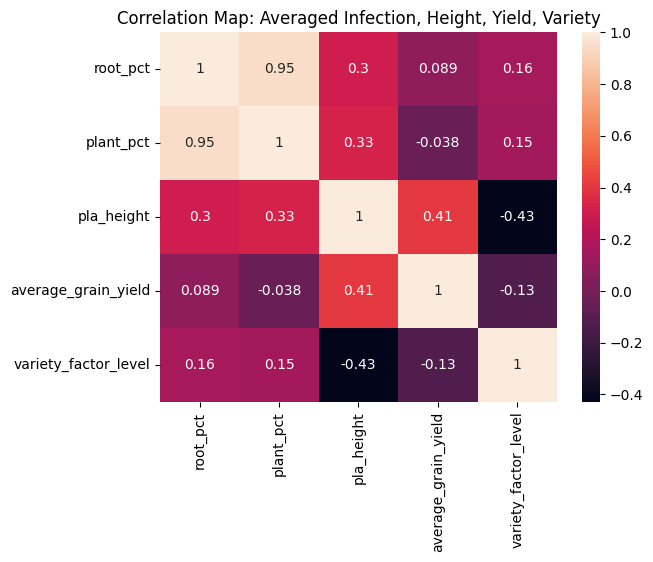

In [76]:
#Developing a correlation matrix between aggregated take all, yield, and plant type

### PROCESS ###

#Estimating the mean infection root percent per year per variety
summary_group = (df.groupby(["harvest_year", "variety_factor_level"])[["root_pct", "plant_pct", "pla_height"]].mean().reset_index())

#Importing yield data
yield_data = pd.read_excel("Yield_760.xlsx")
yield_data['harvest_year'] = pd.to_datetime(yield_data['harvest_year']).dt.year
avg_grain = (yield_data.assign(year = lambda x: pd.to_datetime(x['harvest_year'])).groupby(['harvest_year', 'variety_factor_level'], as_index = False)['ww_grnyld'].mean().rename(columns = {'ww_grnyld': 'average_grain_yield'}))

#Correlation Map dataset
map_df = pd.merge(summary_group, avg_grain, on = ['harvest_year', 'variety_factor_level'], how = 'inner')

#Creating a label encoder for the variety types
label = LabelEncoder()
map_df['variety_factor_level'] = label.fit_transform(map_df['variety_factor_level'])

#Creating heatmap
map_corr = map_df[['root_pct', 'plant_pct', 'pla_height', 'average_grain_yield', 'variety_factor_level']].corr()
sns.heatmap(map_corr, annot = True)
plt.title("Correlation Map: Averaged Infection, Height, Yield, Variety")
plt.show()

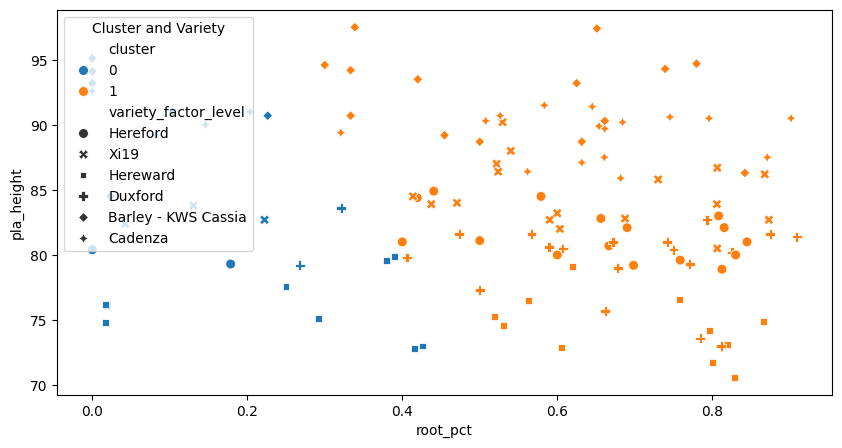

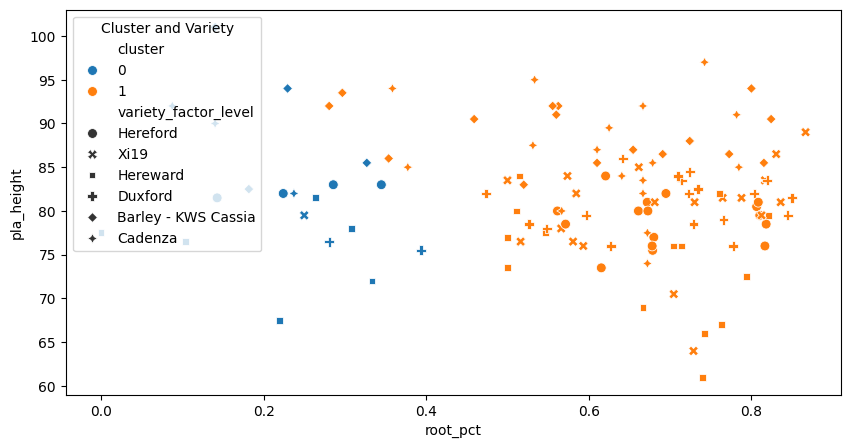

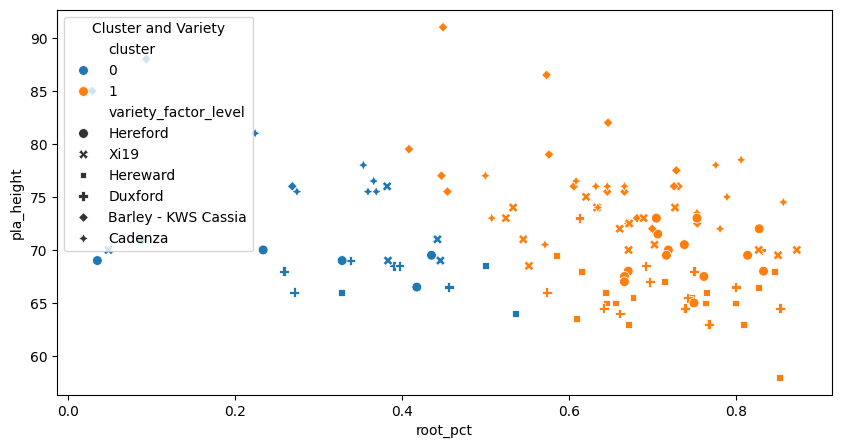

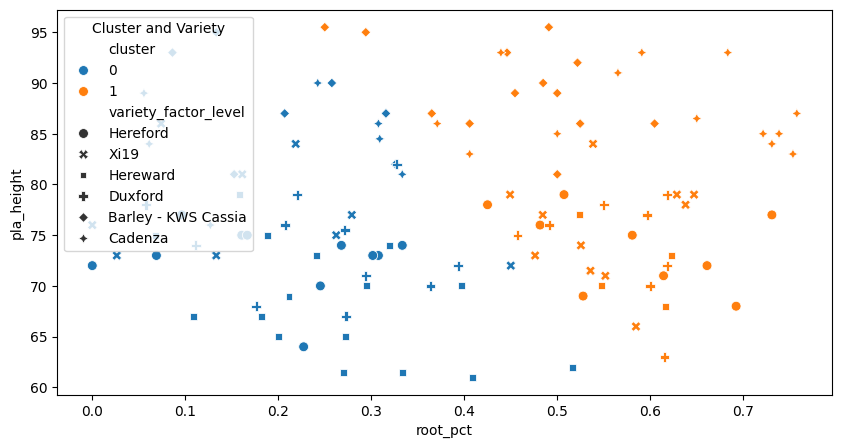

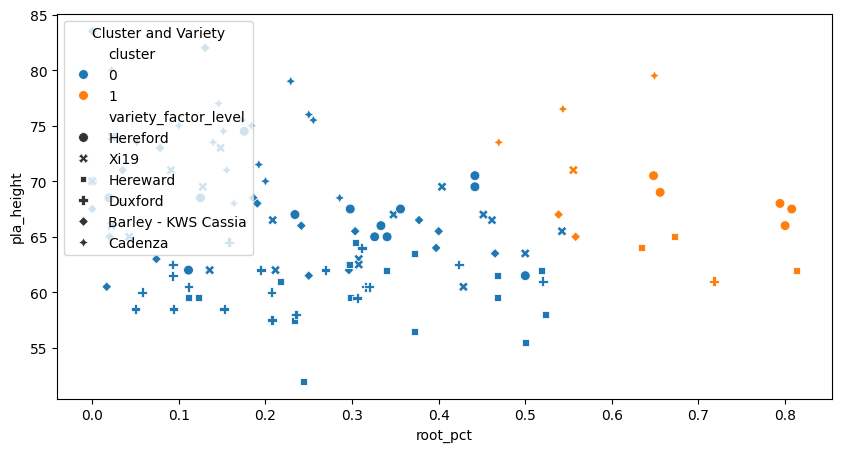

In [77]:
#Do clusters of TEST align with either LOW or HIGH values?
#Can we adequantly explain/observe distinctions between classifications through clustering?

### PROCESS ###
df2 = df[df['harvest_year'] == 2020].copy()

#Scaling and Implementing KMeans Clustering
X_scaled = StandardScaler().fit_transform(df[['root_pct', 'pla_height']])
kmeans = KMeans(n_clusters = 2, random_state = 10)
df["cluster"] = kmeans.fit_predict(X_scaled)

for year in df['harvest_year'].unique():
    year_id = df[df['harvest_year'] == year].copy()
    plt.figure(figsize=(10,5))
    plot_val = sns.scatterplot(data = year_id, x = "root_pct", y = "pla_height", hue = "cluster", style = "variety_factor_level", s = 50)
    sns.move_legend(plot_val, "upper left", title = 'Cluster and Variety')
    
#0 = HIGH and 1 = LOW

### RESULTS ###
#No clear distinction among which varieties are high and low when clustering between plant height and root_pct for most individual years
#Year 4 (2019) shows the most distinction between HIGH and LOW during take all peak

In [78]:
#Logistic Regression Model - Random Forest Model has not enough samples

### PROCESS ###
early_data = df.copy()
early_data["label_num"] = early_data["tab_variety_type"].map({"LOW": 0, "HIGH": 1})
train_data = early_data[(early_data['label_num'] == 1) | (early_data['label_num'] == 0)]
X = train_data[['root_pct', 'pla_height', 'plant_pct']].copy()
y = train_data['label_num']

scale_x = StandardScaler()
X_scale = scale_x.fit_transform(X)

pca_val = PCA(n_components = 2)
X_pca_val = pca_val.fit_transform(X_scale)

X_train, X_test, y_train, y_test = train_test_split(X_pca_val, y, test_size = 0.2, random_state = 10)

log_reg = LogisticRegression(max_iter = 100, class_weight = "balanced")
log_reg.fit(X_train, y_train) 

print("Binomial Test Acc:", accuracy_score(y_test, log_reg.predict(X_test)))

#Binomial classifier is accurate with 80% accuracy

Binomial Test Acc: 0.775


In [79]:
### QUESTION ###
#Can we use this model to predict HIGH and LOW for each variety?

test_val = early_data[early_data['tab_variety_type'] == 'TEST'].copy()
X_class = test_val[['root_pct', 'pla_height', 'plant_pct']]

X_class_scale = scale_x.fit_transform(X_class)
X_pca_val_pred = pca_val.fit_transform(X_class_scale)

test_val['predict_val'] = log_reg.predict(X_pca_val_pred)
test_val['predict_val'] = test_val['predict_val'].map({0: 'LOW', 1: 'HIGH'})
pred_summary = test_val.groupby('variety_factor_level')['predict_val'].agg(lambda x: x.value_counts().reset_index())
pred_summary

### RESULTS ###
#From the Binomial model, Barley was the only variety classified as LOW
#However, Xi19 is similar genetically to Cadenza and should display an overall LOW Inoculum
#Another classification method should be considered to reinforce the results of the binomial classifier


variety_factor_level
Barley - KWS Cassia    [[LOW, 74], [HIGH, 26]]
Duxford                [[HIGH, 61], [LOW, 39]]
Hereford               [[HIGH, 55], [LOW, 43]]
Xi19                   [[LOW, 50], [HIGH, 50]]
Name: predict_val, dtype: object

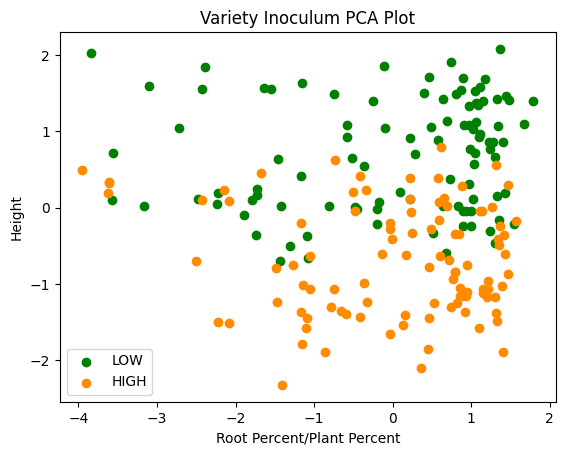

                 PC1       PC2
pla_height  0.071559  0.996989
root_pct    0.706046 -0.029480
plant_pct   0.704541 -0.071719


In [83]:
### AIM ###
#Finding the PCA plot for the SVM Model

### PROCESS ###
#Scaling the X-axis and finding the PCA
df4 = df.copy()
df4["label_num"] = df4["tab_variety_type"].map({"HIGH": 1, "LOW": 0})
train_data = df4[(df4['label_num'] == 1) | (df4['label_num'] == 0)]
X_scaled_all = StandardScaler().fit_transform(train_data[['pla_height','root_pct', 'plant_pct']])
y_all = train_data['tab_variety_type'].map({'HIGH' : 1, 'LOW' : 0})

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_all)

plt.scatter(X_pca[y_all == 0, 0], X_pca[y_all == 0, 1], color = 'green', label = 'LOW')
plt.scatter(X_pca[y_all == 1, 0], X_pca[y_all == 1, 1], color = 'darkorange', label = 'HIGH')
plt.title('Variety Inoculum PCA Plot')
plt.xlabel('Root Percent/Plant Percent')
plt.ylabel('Height')
plt.legend()
plt.show()

loading_val = pd.DataFrame(pca.components_.T, columns = ['PC1', 'PC2'], index = ['pla_height','root_pct', 'plant_pct'])
print(loading_val)

### RESULTS ###
#While there appears to be overlap with the PCA model, Root/Plant Percent and Height create the most separated model

Train accuracy: 0.79375
Test accuracy: 0.775
              precision    recall  f1-score   support

         0.0       0.68      0.88      0.77        17
         1.0       0.89      0.70      0.78        23

    accuracy                           0.78        40
   macro avg       0.79      0.79      0.77        40
weighted avg       0.80      0.78      0.78        40



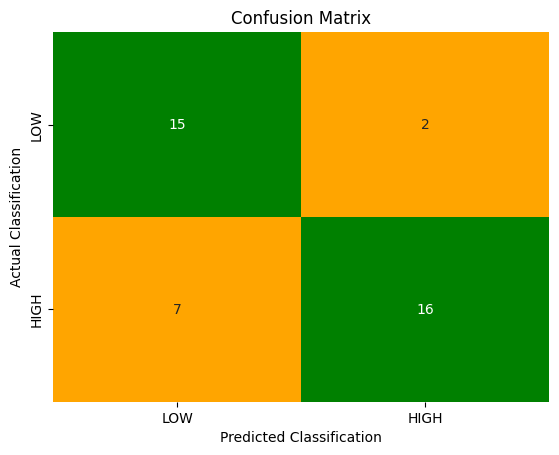

In [117]:
### AIM ###
#SVM for predicting whenever a TEST is HIGH or LOW, used at 2018
#The SVM was selected due to its philosophy of using margin based vectors and ability to account for nonlinear bounaries if needed
#Needs only a moderately sized dataset instead of large for binomial/multinomial. Additionally having a higher focus on model prediction accuracy.

#Average out counts for HIGH and LOW for variety factor level for years 2016-2020
df3 = df.copy()
df3["label_num"] = df3["tab_variety_type"].map({"LOW": 0, "HIGH": 1})
train_data = df3[(df3['label_num'] == 1) | (df3['label_num'] == 0)]

#Scaling, PCA, and Training
X = train_data[['pla_height', 'plant_pct', 'root_pct']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_val = PCA(n_components = 2)
X_pca_val = pca_val.fit_transform(X_scaled)
y = train_data['label_num']

#40 samples were used for testing with 160 in training
X_train, X_test, y_train, y_test = train_test_split(X_pca_val, y, test_size=0.2, random_state=10)
model = SVC(kernel = 'linear', C = 1, degree = 1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

print(classification_report(y_test, y_pred_test))

#Implementing confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

#Adding color theme to confusion matrix
colors = ["green", "orange"]
cmap = ListedColormap(["orange", "green"])


sns.heatmap(cm, annot = True, fmt = "d", cmap = cmap, cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Classification")
plt.ylabel("Actual Classification")

plt.xticks([0.5, 1.5], ["LOW", "HIGH"])
plt.yticks([0.5, 1.5], ["LOW", "HIGH"])

plt.show()

#The overall testing accuracy for the model is greater than that of multinomial
#It's observed that HIGH has a better predicition precision than LOWW
#Overall, basing off root_pct and plant_height, the model is favorable.


In [118]:
### AIM ###
#Making the function for developing the boundary for the SVM 
#Plotting 

### PROCESS ###
#SVM Plot
def plot_svm_decision_boundary(X_pca, y_val, degree, kernel, gamma='scale', C = 1):
    clf = svm.SVC(kernel = kernel, gamma = gamma, degree = degree, C = C)
    clf.fit(X_pca, y_val)
    fig, ax = plt.subplots(figsize = (10, 5))
    
#Decision boundary creation
    disp = DecisionBoundaryDisplay.from_estimator(clf, X_pca, response_method = "predict", cmap = ListedColormap(["orange", "red"]), alpha = 0.3, ax = ax)

#Plotting the decision boundaries between HIGH and LOW
    DecisionBoundaryDisplay.from_estimator(clf, X_pca, response_method = "decision_function", plot_method  = "contour", levels = [-1, 0, 1], colors = "k", linestyles = ["--", "-", "--"], ax = ax)

#Plotting the support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s = 100, facecolors = 'none', edgecolors = 'k', label = 'Support Vectors')

#Plotting the training points, fills in points on thue SVM model
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c = y_val, cmap = ListedColormap(["orange", "red"]), s = 30, edgecolors = 'k')
    plt.title('SVM Model for Plant Pct/Root Pct and Plant Height')
    plt.xlabel('Root Percent/Plant Percent')
    plt.ylabel('Plant Height')
    plt.legend()
    plt.show()

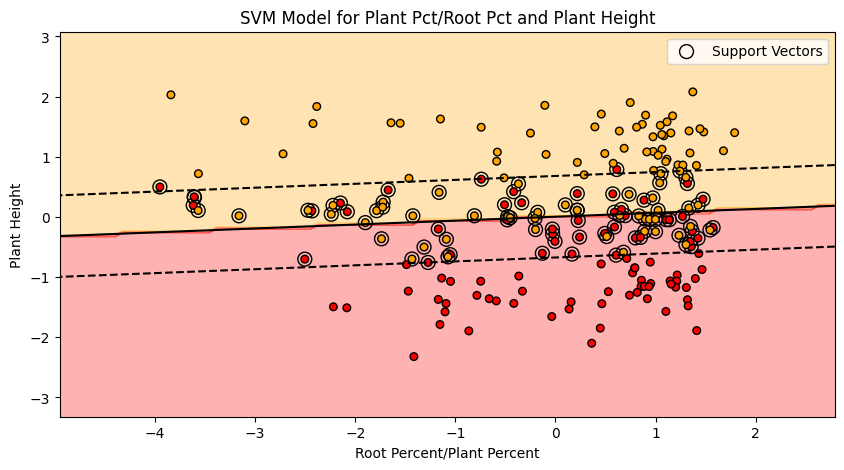

In [119]:
#Calling the SVM function with linear input
plot_svm_decision_boundary(X_pca_val, y.values, kernel='linear', degree = 1)

### RESULTS ###
#Visual inspection of the SVM model shows a linear boundary line that increases with Root/Plant infection percent
#The boundary shows that varieties are more often classified as HIGH with more extreme root/plant percent values

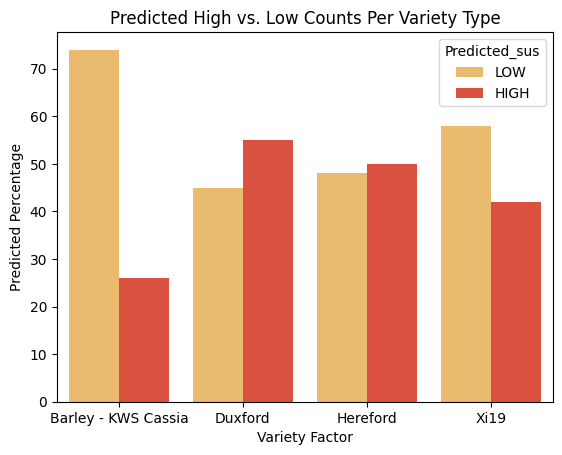

In [120]:
#Classification of wheat varieties
test_var = df[df['tab_variety_type'] == 'TEST'].copy()
X_test = test_var[['pla_height', 'plant_pct', 'root_pct']]


scale_x = scaler.transform(X_test)
pca_scaled_x = pca_val.transform(scale_x)
pred_y = model.predict(pca_scaled_x)

test_var['Predicted_sus'] = np.where(pred_y == 1, 'HIGH', 'LOW')
predicted_var = test_var.groupby('variety_factor_level')['Predicted_sus'].value_counts().reset_index(name = 'count')

sns.barplot(data = predicted_var, x = 'variety_factor_level', y = 'count', hue = 'Predicted_sus', palette = 'YlOrRd')

plt.title('Predicted High vs. Low Counts Per Variety Type')
plt.xlabel('Variety Factor')
plt.ylabel('Predicted Percentage')
plt.show()

#The results show that Xi19 and Barley are the LOW Inoculum classifications
#Duxford and Hereford are inbetween, these classifications can be registered as HIGH or MEDIUM

C:\Users\jackm\AppData\Local\Temp\ipykernel_20904\4119531232.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = avg_by_variety, x = 'variety_factor_level', y = 'Avg_Sus', palette = 'YlOrRd')


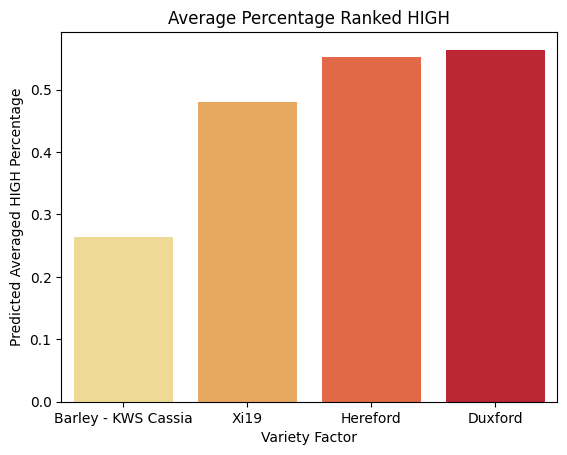

In [121]:
#Finding the averaged for the random_state and plot the percentage of plant varieties that were predicted HIGH
#200 iterations were used when finding the average for HIGH inoculum predictions

#Scaling and train/testing
df4 = df.copy()
df4["label_num"] = df4["tab_variety_type"].map({"HIGH": 1, "LOW": 0})

scale = StandardScaler()

train_data = df4[(df4['label_num'] == 1) | (df4['label_num'] == 0)]
test_data = df4[df4['tab_variety_type'] == 'TEST'].copy()

x_test = test_var[['pla_height', 'root_pct', 'plant_pct']]
x_train = train_data[['pla_height', 'root_pct', 'plant_pct']]
y = train_data['label_num']

x_train_scaled = scale.fit_transform(x_train)
x_test_scaled = scale.transform(x_test)

#PCA transformation
pca = PCA(n_components = 2)
x_pca_train = pca.fit_transform(x_train_scaled)
x_pca_test = pca.transform(x_test_scaled)

#Array for storing the prediciton values
prediction_list = []

#Implementing 200 iterations of the SVM model and adding the responses to an array
for random_state_num in range(200):
    X_train, X_test, y_train, y_test = train_test_split(x_pca_train, y, test_size=0.2, random_state=random_state_num)
    
    model = SVC(kernel = 'linear', C = 1, degree = 1)
    model.fit(X_train, y_train)
    
    y_pred_test = model.predict(x_pca_test)

    prediction_list.append(y_pred_test)

#Computing the averrage predicted HIGH inoculum
#Array is stacked vertically from lists to rows
pred_matrix = np.vstack(prediction_list)
avg_preds = pred_matrix.mean(axis=0)  
test_var['Avg_Sus'] = avg_preds 
avg_by_variety = (test_var.groupby('variety_factor_level')['Avg_Sus'].mean().reset_index())
avg_by_variety = avg_by_variety.sort_values('Avg_Sus').reset_index(drop = True)
avg_by_variety

sns.barplot(data = avg_by_variety, x = 'variety_factor_level', y = 'Avg_Sus', palette = 'YlOrRd')
plt.title('Average Percentage Ranked HIGH')
plt.xlabel('Variety Factor')
plt.ylabel('Predicted Averaged HIGH Percentage')
plt.show()